Same as final-notebook except this one doesn't keep all objects in the same matrix

In [15]:
# Reading the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from copy import copy
from matplotlib import cm, colors
import cv2

emptyRatio = 47
objectwidth = 83
objectheight = 122
xspacing = 133
yspacing = 270
xstart = 293
ystart = 268
xend = 1730
yend = 1770
powderthickness = 80
endlayer = 187

paths = pathlib.Path('./OT data 80 um/int').glob('*.tif')
paths_sorted = [x for x in paths]
paths_sorted.sort()
block = np.array([np.array(plt.imread(path)) for path in paths_sorted])
integrals = block[0:endlayer]

del paths_sorted


In [17]:
objectinfo = pd.read_csv('Parameters.csv', names=["Object", "P", "S", "H", "Porosity", "Label"])
objectsplit = 3
upsamplingratio = 4
positive_multiplier = 2
layersPerObject = endlayer // objectsplit
# Approximate one third test data
testEnd = endlayer - layersPerObject * (objectsplit // 3)

objectinfo.insert(1, "VED", objectinfo.P * 1000/(objectinfo.S * objectinfo.H * powderthickness))
objectCoordinates = [[x, x+objectwidth, y, y+objectheight] for y in reversed(range(
    ystart, yend, objectheight + yspacing)) for x in range(xstart, xend, xspacing + objectwidth)]
coorddf = pd.DataFrame(objectCoordinates, columns=['xstart', 'xend', 'ystart', 'yend'])
objectinfo = coorddf.join(objectinfo)
objectinfo.drop(objectinfo[objectinfo.Label == 'KH'].index, inplace=True)
objectinfo.replace('GOOD', 0, inplace=True)
objectinfo.replace('LOF', 1, inplace=True)

# positive_multiplier = int(1 // np.average(np.array(objectinfo.loc[:,"Label"])))

### Old version before upsampling
# zs = [objectinfo.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject, layersPerObject)]
# testzs = [objectinfo.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(testEnd, endlayer-layersPerObject+1, layersPerObject)]
### End of old version

zs = [objectinfo.copy().assign(zstart=z, zend=z+layersPerObject) for z in range(0, testEnd-layersPerObject, layersPerObject//(upsamplingratio * positive_multiplier))]
testzs = [objectinfo.copy().assign(zstart=testEnd, zend=endlayer)]

trainobjectinfo = pd.concat(zs, ignore_index=True)
# This line removes all the lines from the dataframe that aren't created because of the positive_multiplier
trainobjectinfo = trainobjectinfo[(trainobjectinfo['Label'] == 1) | (trainobjectinfo['zstart'] % (positive_multiplier) == 0)]

testobjectinfo = pd.concat(testzs, ignore_index=True)

trainobjectinfo.reset_index(drop=True, inplace=True)
testobjectinfo.reset_index(drop=True, inplace=True)

del zs
del testzs
del coorddf
del objectCoordinates
del objectinfo

trainobjects = np.full((len(trainobjectinfo), layersPerObject, objectheight, objectwidth), np.nan)
testobjects = np.full((len(testobjectinfo), endlayer-testEnd, objectheight, objectwidth), np.nan)


for index, object in trainobjectinfo.iterrows():
    trainobjects[index] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]
for index, object in testobjectinfo.iterrows():
    testobjects[index] = integrals[object.zstart:object.zend, object.ystart:object.yend, object.xstart:object.xend]

aggregate = np.sum(trainobjects, axis=(0,1))

emptyRatio = 47
limit = np.percentile(aggregate, emptyRatio)
backgroundmask = aggregate >= limit
trainmask = np.repeat([backgroundmask], layersPerObject, 0)

assert(np.average(np.isfinite(trainobjects)) == 1)
assert(np.average(np.isfinite(testobjects)) == 1)
# xs = np.copy(aggregate)
# xs[~backgroundmask] = np.nan
# plt.imshow(xs)
# plt.figure()

In [32]:
from sklearn import neighbors, metrics
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn import preprocessing
from datetime import datetime

def preprocess(objects, type, sharpening, backgroundmask):
    rtn = np.full(objects.shape, np.nan)
    # print(rtn.shape)
    for index, object in enumerate(objects):
        sharpeningKernel = np.array([   [-1, -1,  -1],
                                        [-1,  9,  -1],
                                        [ -1, -1,  -1]
        ]) if sharpening == 'diagonal' else np.array([  [0, -1,  0],
                                                        [-1, 5, -1],
                                                        [0, -1,  0]])
        sharpened = np.array([cv2.filter2D(src=image, ddepth=-1, kernel=sharpeningKernel) for image in object])
        # if(sharpening == 'none'):
        #     sharpened = object
    # Sharpening is done
        if type == 'scatter' or type == 'spatstat':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            (endLayer, _, _) = xs.shape
            xs[~backgroundmask] = np.nan
            rtn[index] = xs
        elif type == 'moran':
            xs = np.array(sharpened, copy=True, dtype=np.float32)
            (endLayer, _, _) = xs.shape
            avg = np.mean(xs, where=backgroundmask)
            stddev = np.std(xs, where=backgroundmask)
            xs = (xs - avg) / avg
            xs[~backgroundmask] = np.nan
            rtn[index] = xs
    return rtn


def calculateoutliers(objects, type, neighbourhoodSetting, windowSize):
    c, z, y, x = objects.shape

    outlierValues = np.full((c, z + 1 - windowSize, y, x), np.nan)
    for index, object in enumerate(objects):
        # Step 1: calculate neighbourhood
        neighbourkernel = np.array(
            [[1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]]
        )/9 if neighbourhoodSetting == 'grid' else np.array(
            [[1, 2,  1],
            [2, 4, 2],
            [1, 2,  1]])/16
        flatNeighbourhood = np.array([cv2.filter2D(src=layer, ddepth=-1, kernel=neighbourkernel) for layer in object])
        neighbourhoodValues = np.array([
            np.sum(flatNeighbourhood[layerIndex-windowSize:layerIndex], axis=0)/windowSize
            for layerIndex in range(windowSize, z+1)
        ])
        # Step 2: calculate outlier
        offset = windowSize // 2
        endoffset = windowSize - offset - 1

        xs = object[offset:z-endoffset]
        ys = neighbourhoodValues[0:z-windowSize+1]
        filter = np.logical_and(np.isfinite(xs), np.isfinite(ys))

        assert(len(set(filter.flatten())) == 2)
        if type == 'spatstat':
            outliers = xs - ys
            avg = np.mean(outliers[filter])
            std = np.std(outliers[filter])
            outliers = (outliers - avg) / std
            outlierValues[index] = outliers
        else:
            # Is the axis right for moran/scatter?
            # print(offset, endoffset, object.shape)
            line = np.polyfit(ys[filter].flatten(), xs[filter].flatten(), 1)
            p = np.poly1d(line)
            outlierValues[index] = xs - p(ys)
            assert(outlierValues[index].shape == xs.shape == p(ys).shape)
        assert(len(np.unique(outlierValues[index])) > 1)
        assert(len(np.unique(np.isfinite(outlierValues[index]))) == 2)
    assert(np.average(np.isfinite(outlierValues)) > 0.4)
    return outlierValues

def encode(outlierobjects, type, buckets, histnormalise, minval=0, maxval=0):
    numberOfObjects, _, _, _ = outlierobjects.shape
    X = np.full((numberOfObjects, buckets), np.nan)
    filter = np.isfinite(outlierobjects)
    minval = np.min(outlierobjects[filter]) if minval == 0 else minval
    maxval = np.max(outlierobjects[filter]) if maxval == 0 else maxval
    for index in range(0, numberOfObjects):
        xs = outlierobjects[index]
        filter = np.isfinite(xs)
        hist, edges = np.histogram(xs[filter], bins=buckets, range=(minval, maxval), density=True)
        X[index] = np.array(hist)
    
    if (histnormalise == 'column'):
        X = preprocessing.normalize(X, axis=0)
    elif (histnormalise == 'row'):
        X = preprocessing.normalize(X, axis=1)
    return X, minval, maxval, edges

def classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors):
    clf = neighbors.KNeighborsClassifier(n_neighbors, metric='cityblock')
    cvscore = cross_val_score(clf, Xtrain, Ytrain, cv=5, scoring='roc_auc', n_jobs=-1).mean()
    clf.fit(Xtrain, Ytrain)
    yfit = clf.predict(Xtest)
    # graph = clf.kneighbors(Xtest, return_distance=False)
    # print(graph)
    # return
    return cvscore, metrics.roc_auc_score(Ytest, yfit), metrics.precision_score(Ytest, yfit, zero_division=0), metrics.recall_score(Ytest, yfit, zero_division=0)

In [37]:
# parameter settings
types = ['scatter', 'spatstat', 'moran', ]
sharpening = ['none', 'direct', 'diagonal']
windowsizes = [1, 3, 5, 7]
neighbourhoodSetting = ['grid', 'euclidean']
bins = [30, 60, 90, 120, 150]
histnormalise = ['none', 'row']
k = [2,3,4,5,10,15,20]

In [38]:
# Now to tie it all together...
columns = ['type', 'sharpening', 'windowSize', 'neighbourhood', 'buckets', 'histnormalise', 'k-nearest', 'cv-auc', 'test-auc', 'test-precision', 'test-recall']
results = pd.DataFrame(columns=columns)
Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
Ytest = np.array(testobjectinfo.loc[:,"Label"])
for type in types:
    for sharpSetting in sharpening:
        print(datetime.now().strftime("%H:%M:%S"), "Processing type: ", type, " sharpening: ", sharpSetting)
        # trainpreprocessed = np.apply_along_axis(preprocess, 1, trainobjects, type, sharpSetting)
        trainpreprocessed =preprocess(trainobjects, type, sharpSetting, trainmask)
        testpreprocessed =preprocess(testobjects, type, sharpSetting, trainmask)
        for windowsize in windowsizes:
            for nSetting in neighbourhoodSetting:
                print(datetime.now().strftime("%H:%M:%S"), "Processing windowSize: ", windowsize, " neighbourhood: ", nSetting)
                trainoutliers = calculateoutliers(trainpreprocessed, type, nSetting, windowsize)
                testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
                
                for histnorm in histnormalise:
                    for bucket in bins:
                        Xtrain, minval, maxval, edges = encode(trainoutliers, type, bucket, histnorm)
                        Xtest, _, _, _ = encode(testoutliers, type, bucket, histnorm, minval=minval, maxval=maxval)
                        for n_neighbors in k:
                            cvscore, score, precision, recall = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors)
                            nextRow =  pd.DataFrame([[type, sharpSetting, windowsize, nSetting, bucket, histnorm, n_neighbors, cvscore, score, precision, recall]], columns=columns)
                            results = pd.concat([results, nextRow])
                        results.to_csv('out13.csv', index=False, header=True)


18:01:21 Processing type:  scatter  sharpening:  none
18:01:22 Processing windowSize:  1  neighbourhood:  grid
18:01:48 Processing windowSize:  1  neighbourhood:  euclidean
18:02:10 Processing windowSize:  3  neighbourhood:  grid
18:02:31 Processing windowSize:  3  neighbourhood:  euclidean
18:02:52 Processing windowSize:  5  neighbourhood:  grid
18:03:12 Processing windowSize:  5  neighbourhood:  euclidean
18:03:33 Processing windowSize:  7  neighbourhood:  grid
18:03:53 Processing windowSize:  7  neighbourhood:  euclidean


KeyboardInterrupt: 

In [ ]:
# Debug cell

type = "moran"
sharpSetting = "diagonal"
windowSize = 5
histnorm = "none"
bucket = 30
nSetting = "euclidean"

columns = ['type', 'sharpening', 'windowSize', 'neighbourhood', 'buckets', 'histnormalise', 'k-nearest', 'auc', 'precision', 'recall']
results = pd.DataFrame(columns=columns)
Ytrain = np.array(trainobjectinfo.loc[:,"Label"])
Ytest = np.array(testobjectinfo.loc[:,"Label"])

# Att validera:
# Träningsset har flera klasser
# Testset har flera klasses
# Bilder i varje steg
assert(set(Ytest) == set(Ytrain))
# trainpreprocessed = np.apply_along_axis(preprocess, 1, trainobjects, type, sharpSetting)
trainpreprocessed = preprocess(trainobjects, type, sharpSetting)
testpreprocessed = preprocess(testobjects, type, sharpSetting)

plt.title("training 22 start")
plt.imshow(trainobjects[2][2])
plt.figure()
plt.title("test 22 start")
plt.imshow(testobjects[2][2])
plt.figure()
plt.title("training 22 preprocessed")
plt.imshow(trainpreprocessed[2][2])
plt.figure()
plt.title("test 22 preprocessed")
plt.imshow(testpreprocessed[2][2])
plt.figure()
# trainoutliers = np.apply_along_axis(calculateoutliers, 1, trainpreprocessed, type, nSetting, windowsize)
trainoutliers = calculateoutliers(trainpreprocessed, type, nSetting, windowsize)
testoutliers = calculateoutliers(testpreprocessed, type, nSetting, windowsize)
print("train 2 outliers: ", np.unique(trainoutliers[2]))
print("test 2 outliers: ", np.unique(testoutliers[2]))
print("train 1 outliers: ", np.unique(trainoutliers[1]))
print("test 1 outliers: ", np.unique(testoutliers[1]))
plt.title("train 22 outliers")
plt.imshow(trainoutliers[2][2])
plt.figure()
plt.title("test 22 outliers")
plt.imshow(testoutliers[2][2])
plt.figure()
Xtrain, minval, maxval = encode(trainoutliers, type, bucket, histnorm)
Xtest, _, _ = encode(testoutliers, type, bucket, histnorm, minval=minval, maxval=maxval)
print("train 2 outliers: ", np.unique(trainoutliers[2]))
print("test 2 outliers: ", np.unique(testoutliers[2]))
print("train 1 outliers: ", np.unique(trainoutliers[1]))
print("test 1 outliers: ", np.unique(testoutliers[1]))
plt.title("train 2 outliers")
plt.hist(trainoutliers[2].flatten(), bins=bucket, range=(minval, maxval))
plt.yscale('log')
plt.figure()
plt.title("test 2 outliers")
plt.hist(testoutliers[2].flatten(), bins=bucket, range=(minval, maxval))
plt.yscale('log')
plt.figure()
plt.title("All outliers")
plt.hist(testoutliers.flatten(), bins=bucket, range=(minval, maxval))
plt.yscale('log')
plt.figure()
# Add encode for test as well
for n_neighbors in k:
    score, precision, recall = classify(Xtrain, Ytrain, Xtest, Ytest, n_neighbors)
    nextRow =  pd.DataFrame([[type, sharpSetting, windowsize, nSetting, bucket, histnorm, n_neighbors, score, precision, recall]], columns=columns)
    results = pd.concat([results, nextRow])
results.to_csv('out2.csv', index=False, header=True)


In [11]:
print("trainobjects (numpy): " + str(hash(np.array2string(trainobjects))))
print("traininfo: " + str(hash(trainobjectinfo.to_string())))
print("testobjects (numpy): " + str(hash(np.array2string(testobjects))))
print("testinfo: " + str(hash(testobjectinfo.to_string())))



trainobjects (numpy): -8066147760671862006
traininfo: 8803907455718943585
testobjects (numpy): -1612893992064633819
testinfo: -6341766382792990118


In [13]:
trainobjectinfo.to_csv("v2train.csv", index=False, header=True)
testobjectinfo.to_csv("v2test.csv", index=False, header=True)

In [5]:
np.savetxt("v2train.csv", trainobjects.flatten(), delimiter=",", fmt='%1.3e')
np.savetxt("v2test.csv", testobjects.flatten(), delimiter=",", fmt='%1.3e')

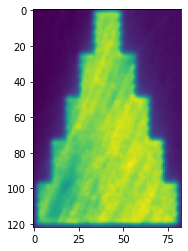

In [8]:
plt.imshow(trainobjects[0][0])